In [8]:
import re
import os
from fears.utils import AutoRate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import pickle
import pandas as pd
import calibration_08302023 as cal

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

# with open('../rfu_to_dilution.pkl','rb') as f:
#     rfu30_to_dilution = pickle.load(f)
#     f.close()

folder = '../experiment_data/max_death_rate_11032023'

exp_layout = {0:(0,['B','C','D']), # each genotype is associated with a tuple corresponding to the excel sheet number and the list of rows
              3:(0,['E','F','G']),
              5:(1,['B','C','D']),
              9:(1,['E','F','G']),
              10:(2,['B','C','D'])}

time = np.array([0,15,48,60,80,115,150,210,270,330])

rfu30_to_dilution = cal.run()

In [9]:
# takes a fodler of excel files and returns a list of plates and a list of data
# each element in the list corresponds to a plate scan
# specify plate num to get the data from a specific excel sheet

def get_timeseries(folder_path,plate_num):
    plate_files = os.listdir(folder_path)

    # filter and sort the files
    plate_files = [p for p in plate_files if p.endswith('.xlsx')]
    plate_files.sort(key=natural_keys)

    plates = []
    data = []
    for plate_file in plate_files:
        if plate_file[0] != '~': # ignore temporary files
            path_t = os.getcwd() + os.sep + folder_path + os.sep + plate_file # path to the excel file

            # get a plate object corresponding to the excel file
            p = AutoRate.Plate(path_t,mode='single_measurement',sheet_name=plate_num)
            plates.append(p)

            # put the data in dictionary format with keys corresponding to the well names 
            data.append(p.od_data_to_dict(p.data))
            
    return plates,data

In [10]:
# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():
# for exp_key in [0]:

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder,plate_num=exp_layout[exp_key][0])

    time_list = []

    data_t = np.zeros((3,9))

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            # col = i
            # for col in range(10):
            if i != 2: # ignore column 2 because of experimental mistake
                key = row + str(i+2) # col+2 because we start the experiment at col 2
                data_t[row_indx,i] = data[i][key]
                    # col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)
    cell_count_mean[exp_key] = np.nanmean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.nanstd(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.nanstd(np.log10(cell_count_data),axis=0)/np.sqrt(3)

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

# time = [element for i, element in enumerate(time) if i != 2]

cell_count_1103 = cell_count_mean
cell_count_1103_err = cell_count_err
cell_count_1103_log_err = cell_count_log_err
time_1103 = time

/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_15004/2767853337.py:45: RuntimeWarning: Mean of empty slice
  cell_count_mean[exp_key] = np.nanmean(cell_count_data,axis=0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_15004/2767853337.py:45: RuntimeWarning: Mean of empty slice
  cell_count_mean[exp_key] = np.nanmean(cell_count_data,axis=0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/pz/780f5rtx09xg5tblgt0ngytwvwx01r/T/ipykernel_15004/2767853337.py:45: RuntimeWarning: Mean of empty slice
  cell_count_mean[exp_key] = np.nanmean(cell_count_data,axis=0)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1872: 

In [16]:
cell_count_data

array([[210697.11071804, 455803.72164785,             nan,
        310990.60413823, 315209.05211275, 209856.3013412 ,
        262905.25533581, 210024.33040136, 152760.1954177 ],
       [233778.37073535, 227966.93131904,             nan,
        188354.94132753, 371587.08873799, 284706.74027832,
        351097.35643678, 526808.69243293, 158852.65956369],
       [230423.5582541 , 299064.57982708,             nan,
        237621.38122525, 471380.71953053, 257970.51391983,
        323397.45682413, 482028.35304585, 227547.10217466]])

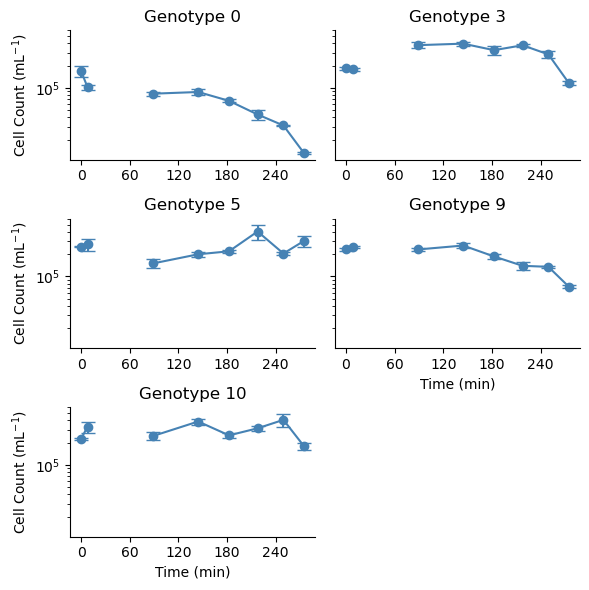

In [15]:
fig,ax_list = plt.subplots(nrows=3,ncols=2,figsize=(6,6),sharey=True)
# fig,ax = plt.subplots()
ax_list = ax_list.flatten()

indx = 0
for key in cell_count_mean.keys():
    ax = ax_list[indx]
    ax.errorbar(time,cell_count_mean[key],yerr=cell_count_err[key],
                fmt='o',capsize=5,label=key, color='steelblue')
    
    ax.plot(time,cell_count_mean[key],color='steelblue')
    ax.set_yscale('log')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_title('Genotype ' + str(key))
    
    indx+=1

ax_list[-1].remove()

for ax in ax_list[:-1]:
    ax.set_xticks(np.arange(0,np.max(time),60))

ax_list[0].set_ylabel('Cell Count (mL$^{-1}$)')
ax_list[2].set_ylabel('Cell Count (mL$^{-1}$)')
ax_list[4].set_ylabel('Cell Count (mL$^{-1}$)')

ax_list[4].set_xlabel('Time (min)')
ax_list[3].set_xlabel('Time (min)')


fig.tight_layout()

In [13]:
cell_count_mean

{0: array([169390.00809874, 101972.693446  ,             nan,  83644.92577314,
         88163.05851048,  66964.52122285,  43782.69143336,  31103.36392213,
         13216.62917498]),
 3: array([184868.21676833, 177638.33053569,             nan, 378588.77262192,
        396890.46662643, 324013.29631752, 377332.24567093, 284180.09668838,
        116399.60612136]),
 5: array([253161.51844588, 271052.14995993,             nan, 149825.97409793,
        199268.88705763, 218630.15181079, 404662.96379356, 204059.20287452,
        301429.74097481]),
 9: array([233969.75759041, 250767.04816514,             nan, 231405.86373577,
        261547.49297572, 186294.49873595, 139199.99119092, 134770.76476274,
         72639.09827903]),
 10: array([224966.34656917, 327611.74426466,             nan, 245655.64223033,
        386058.95346042, 250844.51851312, 312466.68953224, 406287.12529338,
        179719.98571869])}

ValueError: array must not contain infs or NaNs

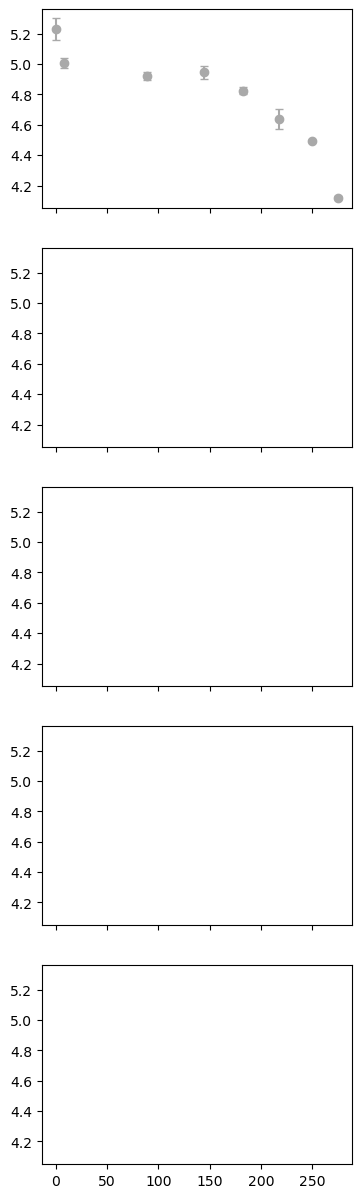

In [14]:
fig,ax_list = plt.subplots(nrows=5,figsize=(4,15),sharex=True,sharey=True)

cmap = mpl.colormaps['viridis']
def growth_diffeq(N,t,K,Kss,alpha,cc):

    dydt = (K-Kss*(1-np.exp(-alpha*t)))*N*(1-N/cc)

    return dydt

def growth_sol(t,y0,K,Kss,alpha,cc):
    y = odeint(growth_diffeq,y0,t,args=(K,Kss,alpha,cc))
    return y[:,0]

cc = 7
K = 0.014

xfit = np.linspace(0,np.max(time+30),100)

row_indx = 0

for key in cell_count_mean.keys():
    ax = ax_list[row_indx]

    y = np.log10(cell_count_mean[key])
    # y = y-y[0] + 3

    ax.errorbar(time,y,yerr=cell_count_log_err[key],fmt='o',color='darkgrey',capsize=3)

    p0 = [2,0.1,0.1]
    bounds = [[1,0,0],[7,1,1]]

    popt,pcov = curve_fit(lambda time, y0, Kss, alpha: growth_sol(time,y0, K,Kss,alpha,cc),
                        time,y,p0=p0,maxfev=10000,bounds=bounds)#,sigma=cell_count_log_err[key])
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    resid = y-growth_sol(time,y0,K,Kss,alpha,cc)

    ax.plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)

    err = np.sqrt(np.diag(pcov))

    ax.annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
                'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}" + '\n'
                '$R^2$ = ' + str(np.round(1-np.sum(resid)/np.sum((y-np.mean(y))**2),3)), xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    row_indx += 1

ax_list[-1].set_xlabel('Time (min)',fontsize=12)
ax_list[2].set_ylabel('Normalized cell count (log10)',fontsize=12)

In [ ]:
# compare all three experiments

# cell_count_1103 = cell_count_mean
# cell_count_1103_err = cell_count_err
# time_1103 = time

folder = '../experiment_data/max_death_rate_10312023'

# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder,plate_num=exp_layout[exp_key][0])

    time_list = []

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        data_t = np.zeros((3,10))

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            col_indx = 0
            for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
                key = row + str(col+2) # col+2 because we start the experiment at col 2
                data_t[row_indx,col_indx] = data[i][key]
                col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)*10**6
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

cell_count_1031 = cell_count_mean
cell_count_1031_err = cell_count_err
cell_count_log_err_1031 = cell_count_log_err
time_1031 = time

In [ ]:
folder = '../experiment_data/tk_10172023'

# re-format data into dictionary with keys corresponding to genotypes
# elements of the dicts are timeseries data

mean_dict = {} # mean fluorescence
err_dict = {} # standard error of the mean

cell_count_mean = {} # mean cell count
cell_count_err = {} # standard error of the mean
cell_count_log_err = {} # standard error of the mean of the log

# B-D and E-G are replicates

for exp_key in exp_layout.keys():

    # get the data for a specific excel sheet
    plate,data = get_timeseries(folder,plate_num=exp_layout[exp_key][0])

    time_list = []

    for i in range(len(data)):

        dt = plate[i].get_start_time()
        time_list.append(dt)

        # arrange data (replicates,timepoints)
        data_t = np.zeros((3,10))

        row_indx = 0 # replicate index
        for row in exp_layout[exp_key][1]:
            col_indx = 0
            for col in range(10):
                # if col != 2: # ignore column 2 because of experimental mistake
                key = row + str(col+2) # col+2 because we start the experiment at col 2
                data_t[row_indx,col_indx] = data[i][key]
                col_indx += 1
            row_indx += 1

    mean_dict[exp_key] = np.mean(data_t,axis=0)
    err_dict[exp_key] = np.std(data_t,axis=0)/np.sqrt(3)

    cell_count_data = rfu30_to_dilution(data_t)*10**6
    cell_count_mean[exp_key] = np.mean(cell_count_data,axis=0)
    cell_count_err[exp_key] = np.std(cell_count_data,axis=0)/np.sqrt(3)
    cell_count_log_err[exp_key] = np.std(np.log10(cell_count_data),axis=0)/np.sqrt(3)

# get the sample times

time = []

t0 = time_list[0]
for t in time_list:
    time.append((t-t0).total_seconds()/60)

time = np.array(time)

cell_count_1017 = cell_count_mean
cell_count_1017_err = cell_count_err
time_1017 = time

Text(0.5, 1.05, 'Genotype 0 experiments')

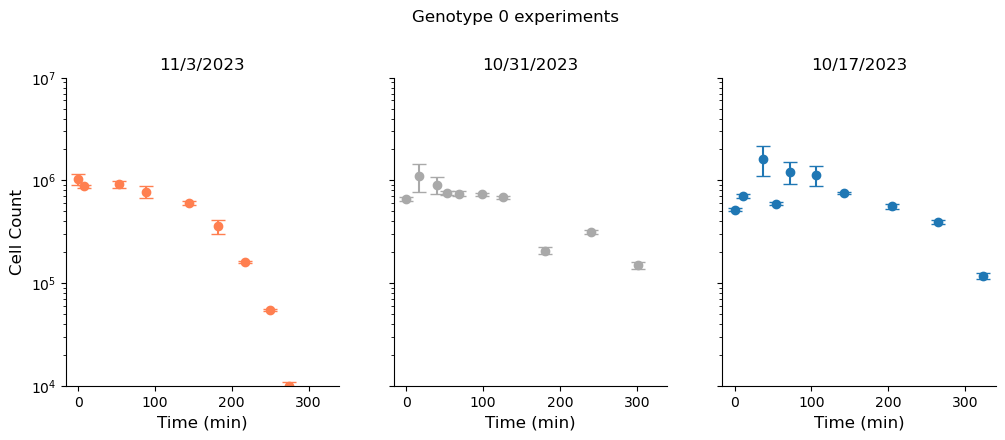

In [ ]:
fig,ax_list = plt.subplots(ncols=3,figsize=(12,4),sharey=True,sharex=True)

# time_1103 = [t+30 for t in time_1103]

ax_list[0].errorbar(time_1103,cell_count_1103[0],yerr=cell_count_1103_err[0],fmt='o',capsize=5,label='11/3/2023',
            color='coral')

ax_list[0].set_title('11/3/2023')
# ax.set_yscale('log')

# fig,ax = plt.subplots()

ax_list[1].errorbar(time_1031,cell_count_1031[0],yerr=cell_count_1031_err[0],fmt='o',capsize=5,label='10/31/2023',
            color='darkgrey')

ax_list[1].set_title('10/31/2023')
# # ax.set_yscale('log')

# # fig,ax = plt.subplots()

ax_list[2].errorbar(time_1017,cell_count_1017[0],yerr=cell_count_1017_err[0],fmt='o',capsize=5,label='10/17/2023',
            color='tab:blue')

ax_list[2].set_title('10/17/2023')

ax_list[0].set_yscale('log')
ax_list[0].set_ylabel('Cell Count',fontsize=12)


for ax in ax_list:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time (min)',fontsize=12)
    ax.set_ylim(10**4,10**7)

fig.suptitle('Genotype 0 experiments',fontsize=12,y=1.05)

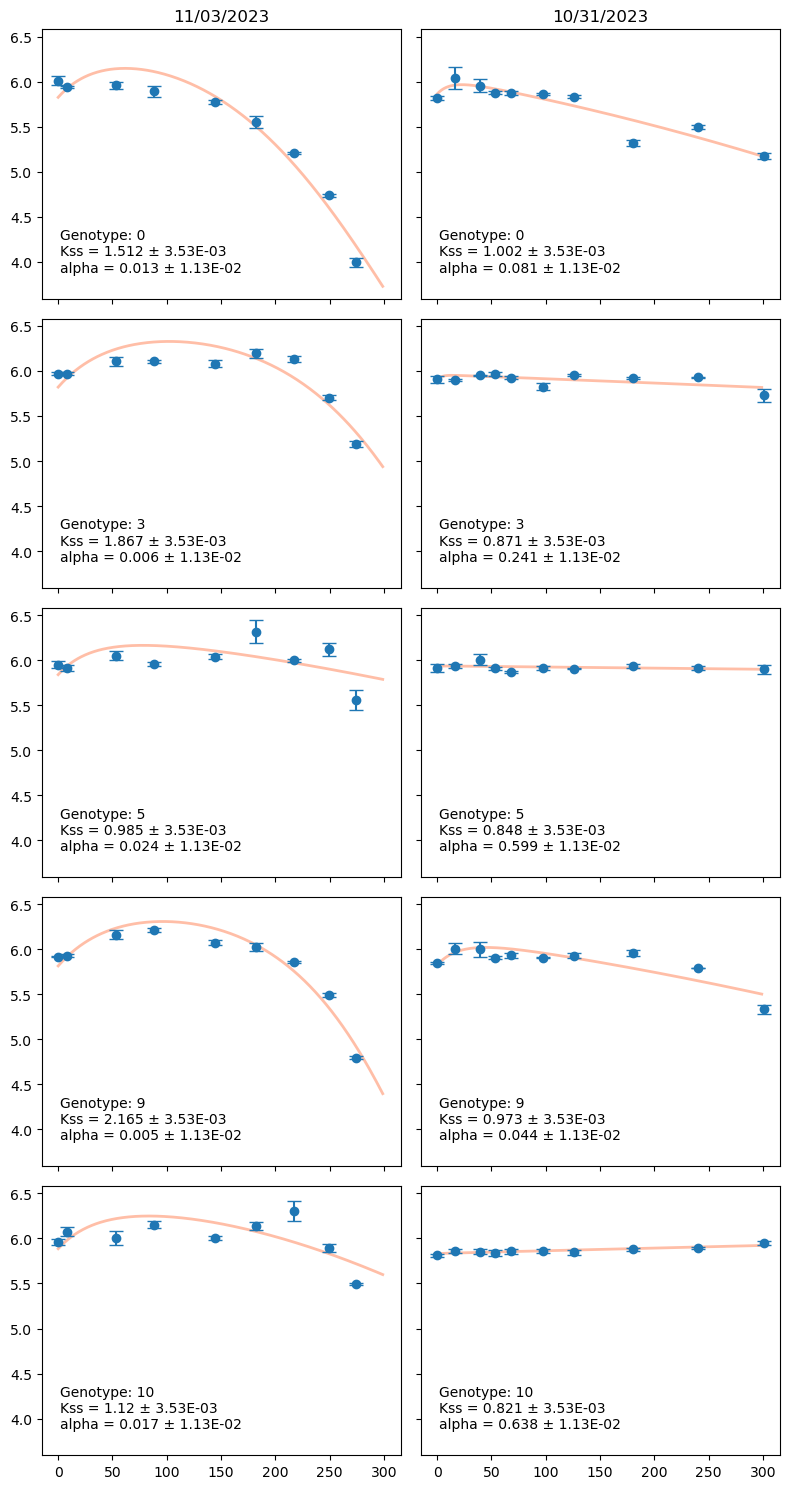

In [ ]:
fig,ax_list = plt.subplots(ncols=2,nrows=5,figsize=(8,15),sharey=True,sharex=True)

xfit = np.arange(0,300,1)

row_indx = 0
for key in cell_count_1103.keys():

    y = np.log10(cell_count_1103[key])
    yerr = cell_count_1103_log_err[key]

    p0 = [2,0.1,0.1]
    bounds = [[1,0,0],[7,1,1]]

    popt,pcov = curve_fit(lambda time_1103, y0, Kss, alpha: growth_sol(time_1103,y0, K,Kss,alpha,cc),
                        time_1103,y,p0=p0,maxfev=10000,bounds=bounds)#,sigma=yerr)
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    ax_list[row_indx,0].plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)
    ax_list[row_indx,0].errorbar(time_1103,y,yerr=yerr,fmt='o',capsize=5,label=key)

    ax_list[row_indx,0].annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
            'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}", xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)

    # y = np.log10(cell_count_1031[key])
    y = cell_count_1031[key]
    yerr = cell_count_log_err_1031[key]

    yerr = np.delete(yerr,y<0)
    time_t = np.delete(time_1031,y<0)
    y = np.delete(y,y<0)

    y = np.log10(y)

    popt,pcov = curve_fit(lambda time_t, y0, Kss, alpha: growth_sol(time_t,y0, K,Kss,alpha,cc),
                        time_t,y,p0=p0,maxfev=10000,bounds=bounds)#,sigma=yerr)
    
    y0 = popt[0]
    Kss = popt[1]
    alpha = popt[2]
    yfit = growth_sol(xfit,y0,K,Kss,alpha,cc)

    ax_list[row_indx,1].plot(xfit,yfit,'-',color='coral',linewidth=2,alpha=0.5)
    ax_list[row_indx,1].errorbar(time_t,y,yerr=yerr,fmt='o',capsize=5,label=key)

    ax_list[row_indx,1].annotate('Genotype: ' + str(key) + '\n' + 'Kss = ' + str(np.round(Kss*60,3)) + " ± " + f"{err[1]:.2E}" + '\n' + 
            'alpha = ' + str(np.round(alpha,3)) + " ± " + f"{err[2]:.2E}", xy=(0.05,0.1),xycoords='axes fraction',fontsize=10)
    
    row_indx += 1

ax_list[0,0].set_title('11/03/2023')
ax_list[0,1].set_title('10/31/2023')

fig.tight_layout()